In [2]:
import numpy as np
import pandas as pd
import math
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow_probability.python.math import random_rademacher

In [3]:
df = pd.read_csv("data/flattened_data.csv", index_col = "datetime")

In [4]:
df.dtypes

1INCHBUSD_open      float64
1INCHBUSD_high      float64
1INCHBUSD_low       float64
1INCHBUSD_close     float64
1INCHBUSD_volume    float64
                     ...   
ZRXUSD_open         float64
ZRXUSD_high         float64
ZRXUSD_low          float64
ZRXUSD_close        float64
ZRXUSD_volume       float64
Length: 1955, dtype: object

In [5]:
# check if market bearish
df2 = df.copy()
print(df.shape)
ilist = []
for i in range(len(df.columns)):
    if i%5!=3:
        ilist.append(i)
df2 = df2.drop(df.columns[ilist],axis = 1)
print(df2.shape)
price_list = df2.iloc[0]
print(len(price_list))

(3624, 1955)
(3624, 391)
391


In [6]:
# Normalize the data ¯\_(ツ)_/¯
x = df.values #returns a numpy array
df = pd.DataFrame(x, columns = df.columns)
df.head

<bound method NDFrame.head of       1INCHBUSD_open  1INCHBUSD_high  1INCHBUSD_low  1INCHBUSD_close  \
0              2.410           2.450          2.406            2.429   
1              2.434           2.441          2.421            2.424   
2              2.423           2.444          2.418            2.434   
3              2.433           2.449          2.433            2.435   
4              2.436           2.454          2.415            2.428   
...              ...             ...            ...              ...   
3619           0.967           0.972          0.953            0.964   
3620           0.963           0.965          0.960            0.965   
3621           0.964           0.964          0.958            0.961   
3622           0.960           0.966          0.953            0.965   
3623           0.965           0.981          0.961            0.978   

      1INCHBUSD_volume  1INCHUSD_open  1INCHUSD_high  1INCHUSD_low  \
0              27034.1          2.3

In [7]:
## split the dataset into 70:15:15
last_15 = sorted(df.index.values)[-int(0.15*len(df))] # Last 15% indices
last_30 = sorted(df.index.values)[-int(0.3*len(df))] 

train_data = df[(df.index < last_30)].values
val_data = df[(df.index >= last_30) & (df.index < last_15)].values
test_data = df[(df.index >= last_15)].values

print('Training set shape: {}'.format(train_data.shape))
print('Validation set shape: {}'.format(val_data.shape))
print('Test data set: {}'.format(test_data.shape))

Training set shape: (2537, 1955)
Validation set shape: (544, 1955)
Test data set: (543, 1955)


In [8]:
# standardize the dataset
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [9]:
# reshape the data with to window size
seq_len = 336 #30

def reshape_data(seq_len, data):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[:][i])
    X, y = np.array(X), np.array(y)
    return X, y

x_train, y_train = reshape_data(seq_len, train_data)
x_val, y_val = reshape_data(seq_len, val_data)
x_test, y_test = reshape_data(seq_len, test_data)

print('Training set shape', x_train.shape, y_train.shape)
print('Validation set shape', x_val.shape, y_val.shape)
print('Testing set shape' ,x_test.shape, y_test.shape)
print(df.shape)


Training set shape (2201, 336, 1955) (2201, 1955)
Validation set shape (208, 336, 1955) (208, 1955)
Testing set shape (207, 336, 1955) (207, 1955)
(3624, 1955)


In [10]:
profit = 0
x_test_last = x_test[:, -1, :]

print(x_test_last.shape)
x_test_last_close = []
y_test_close = []
y_test_pred_close = []
for i in range(x_test_last.shape[1]):
    if i%5 ==3:
        x_test_last_close.append(x_test_last[:,i])
        y_test_close.append(y_test[:,i])
        # y_test_pred_close.append(y_test_pred[:,i])
x_test_last_close = np.transpose(np.array(x_test_last_close))
y_test_close = np.transpose(np.array(y_test_close))
# y_test_pred_close = np.transpose(np.array(y_test_pred_close))
print(x_test_last_close.shape)
print(y_test_close.shape)
# print(y_test_pred_close.shape)

loss_money = 0
profit_money = 0
for i in range(x_test_last_close.shape[0]):
    for j in range(x_test_last_close.shape[1]):
        if x_test_last_close[i,j] != 0:
            profit = profit - 1000 + 1000*(y_test_close[i, j]/x_test_last_close[i,j])
print(profit)


(207, 1955)
(207, 391)
(207, 391)
5936.3470905793765


In [11]:
# Batch size
BATCH_SIZE = 1024

# Number of training epochs
EPOCHS = 100

# Learning rate
L_RATE = 1e-4

# Proportion of samples to hold out
VAL_SPLIT = 0.2

In [12]:
# Xavier initializer
def xavier(shape):
    return tf.random.truncated_normal(
        shape, 
        mean=0.0,
        stddev=np.sqrt(2/sum(shape)))

In [13]:
class BayesianDenseLayer(tf.keras.Model):
    """A fully-connected Bayesian neural network layer
    
    Parameters
    ----------
    d_in : int
        Dimensionality of the input (# input features)
    d_out : int
        Output dimensionality (# units in the layer)
    name : str
        Name for the layer
        
    Attributes
    ----------
    weight : tensorflow_probability.distributions.Normal
        Variational distributions for the network weights
    bias : tensorflow_probability.distributions.Normal
        Variational distributions for the network biases
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the layer
    """

    def __init__(self, d_in, d_out, name=None):
        super(BayesianDenseLayer, self).__init__(name=name)
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
        
    
    @property
    def weight(self):
        return tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
    
    
    @property
    def bias(self):
        return tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        
        
    def call(self, x, sampling=True):
        if sampling:
            return x @ self.weight.sample() + self.bias.sample()        
        else:
            return x @ self.w_loc + self.b_loc
            
            
    @property
    def losses(self):
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.bias, prior)))

In [14]:
class BayesianDenseLayer(tf.keras.Model):
    """A fully-connected Bayesian neural network layer
    
    Parameters
    ----------
    d_in : int
        Dimensionality of the input (# input features)
    d_out : int
        Output dimensionality (# units in the layer)
    name : str
        Name for the layer
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the layer
    """
    
    def __init__(self, d_in, d_out, name=None):
        
        super(BayesianDenseLayer, self).__init__(name=name)
        self.d_in = d_in
        self.d_out = d_out
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
    
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""
        
        if sampling:
        
            # Flipout-estimated weight samples
            s = random_rademacher(tf.shape(x))
            r = random_rademacher([x.shape[0], self.d_out])
            w_samples = tf.nn.softplus(self.w_std)*tf.random.normal([self.d_in, self.d_out])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Flipout-estimated bias samples
            r = random_rademacher([x.shape[0], self.d_out])
            b_samples = tf.nn.softplus(self.b_std)*tf.random.normal([self.d_out])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
        
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))

In [15]:
class BayesianDenseNetwork(tf.keras.Model):
    """A multilayer fully-connected Bayesian neural network
    
    Parameters
    ----------
    dims : List[int]
        List of units in each layer
    name : str
        Name for the network
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors, 
        over all layers in the network
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the network
    """
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""

        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return tf.reduce_sum([s.losses for s in self.steps])

In [16]:
class BayesianDenseRegression(tf.keras.Model):
    """A multilayer Bayesian neural network regression
    
    Parameters
    ----------
    dims : List[int]
        List of units in each layer
    name : str
        Name for the network
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors, 
        over all layers in the network
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the network, predicting both means and stds
    log_likelihood : tensorflow.Tensor
        Compute the log likelihood of y given x
    samples : tensorflow.Tensor
        Draw multiple samples from the predictive distribution
    """    
    
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseRegression, self).__init__(name=name)
        
        # Multilayer fully-connected neural network to predict mean
        self.loc_net = BayesianDenseNetwork(dims)
        
        # Variational distribution variables for observation error
        self.std_alpha = tf.Variable([10.0], name='std_alpha')
        self.std_beta = tf.Variable([10.0], name='std_beta')

    
    def call(self, x, sampling=True):
        """Perform forward pass, predicting both means + stds"""
        
        # Predict means
        loc_preds = self.loc_net(x, sampling=sampling)
    
        # Predict std deviation
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        transform = lambda x: tf.sqrt(tf.math.reciprocal(x))
        N = x.shape[0]
        if sampling:
            std_preds = transform(posterior.sample([N]))
        else:
            std_preds = tf.ones([N, 1])*transform(posterior.mean())
    
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(preds[:,0], preds[:,1]).log_prob(y[:,0])
    
    
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from the predictive distribution"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
                
        # Loss due to network weights
        net_loss = self.loc_net.losses

        # Loss due to std deviation parameter
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        prior = tfd.Gamma(10.0, 10.0)
        std_loss = tfd.kl_divergence(posterior, prior)

        # Return the sum of both
        return net_loss + std_loss

In [17]:
model1 = BayesianDenseRegression([7, 256, 128, 64, 32, 1])

In [18]:
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

C:\Users\ASUS Zephyrus G15\CSCI\jin\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model1.log_likelihood(x_data, y_data)
        kl_loss = model1.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model1.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model1.trainable_variables))
    return elbo_loss

In [34]:
# Make a TensorFlow Dataset from training data
N_train = x_train.shape[0]
data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(N_train )

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
N_val = x_val.shape[0]
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

In [31]:
# Fit the model
elbo1 = np.zeros(EPOCHS)
mae1 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo1[epoch] += train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model1(x_data, sampling=False)[:, 0]
        mae1[epoch] = mean_absolute_error(y_pred, y_data)

NameError: name 'data_train' is not defined

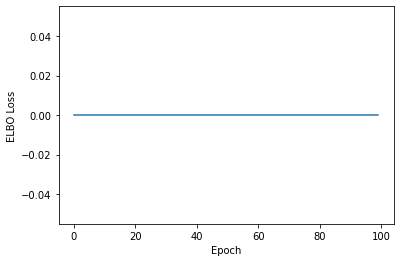

In [32]:
# Plot the ELBO loss
plt.plot(elbo1)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

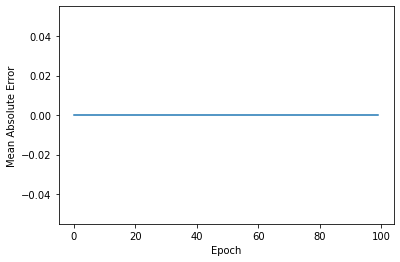

In [33]:
# Plot validation error over training
plt.plot(mae1)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()